### The Dataset is stored in the ```dataset``` folder 
downloaded from ```https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz```
### The GloVe vector embeddings are in the ```glove``` folder 
downloaded from ```https://github.com/stanfordnlp/GloVe```
### The Counter-Fitted vectors are in the ```counter-fitted``` folder
download from ```https://github.com/nmrksic/counter-fitting/blob/master/word_vectors/counter-fitted-vectors.txt.zip```
(see referenced paper [20])


# Import dependecies 
### Start by importing all the required libraries

In [ ]:
"""
Python 3.8.5
Tensorflow 2.2.0
Keras 2.4.3

wordcloud 1.8.0
"""
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import string # use this to remove punctuation from tweets e.g. string.punctuation
import random as rnd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pickle
import os
import re



############ TAR FILE LOCATION AND NAME #########################################
DATASET_URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATASET_TAR_FILE_NAME = "aclImdb_v1.tar.gz"
#################################################################################


############ LOCATION OF CLEANED DATASET FILE ###################################
CLEAN_DATA_FILE = "IMDB_clean_data.csv"
#################################################################################


############ IMDB DATA FOLDER LOCATIONS #########################################
DATASET_FOLDER = "imdb_dataset"
IMDB_FOLDER_NAME = "imdb"
DATA_SET_IMDB = DATASET_FOLDER+"/"+IMDB_FOLDER_NAME+"/"
#################################################################################


############ SAVE MODEL AND TRAINING HISTORY ####################################
MODEL_SAVE_PATH = "../models/imdb_model.hdf5"
TRAINING_HISORTY_SAVE_PATH = "../models/imdb_model_history.csv"
#################################################################################


############ GLOVE AND COUNTER-FITTED VECOR FILE LOCATIONS ######################
COUNTER_FITTED_VECTORS = "counter-fitted/counter-fitted-vectors.txt" 
GLOVE_EMBEDDINGS = "glove/glove.840B.300d.txt"
#################################################################################


############ SENTIMENT MODEL TRAINING PARAMETERS ################################
DIMENSION = 300
LEARNING_RATE = 1e-5
BATCH_SIZE = 64
EPOCHS = 20
#################################################################################


############ DATA SPLIT PERCENTAGE ##############################################
TRAINING_SPLIT = 0.75
#################################################################################


############ DATAFILE IS DOWNLOADED (for fresh download set this to False) ######
DATASET_DOWNLOADED = True
#################################################################################

# Download the dataset and extract contents to correct directories

In [2]:
from manny_train import file_download_extraction as fde


# DATASET_DOWNLOADED = False  # uncomment this line if you want to download a fresh copy of the dataset
TAR_FILE_PATH = DATASET_FOLDER+"/"+DATASET_TAR_FILE_NAME # where to extract the contents

from_folder =""
to_folder = DATASET_FOLDER+"/"+IMDB_FOLDER_NAME

if DATASET_DOWNLOADED:
    print("If you want to download a fresh copy of the data set,")
    print("make sure the variable DATASET_DOWNLOADED is set to False")
else:
    DATASET_DOWNLOADED = True
    fde.download(DATASET_URL, dest_folder=DATASET_FOLDER)
    fde.extract_tar_file(TAR_FILE_PATH, DATASET_FOLDER)
    
    directories_in_dataset_folder = fde.get_directory_name(DATASET_FOLDER)

    if len(directories_in_dataset_folder) == 1:
        from_folder=DATASET_FOLDER+"/"+directories_in_dataset_folder[0]
        fde.rename_folder(from_folder, to_folder)
    else:
        print("ERROR!")
        print(DATASET_FOLDER," folder has too many sub directories!")
    
    

If you want to download a fresh copy of the data set,
make sure the variable DATASET_DOWNLOADED is set to False


# Process dataset
### Read the dataset file and return a data frame and show the first 5 rows of the data frame

In [3]:
from manny_train import IMDB_data_processing as data_process

data_frame  = data_process.process_dataset_IMDB(DATA_SET_IMDB)
data_frame.head()


,sentiment,text
0,0,"I found the documentary entitled Fast, Cheap, ..."
1,0,This is an embarrassment to everyone and every...
2,0,"The cast although nothing special, all do an O..."
3,0,Investigative reporter Darren McGavin (as Carl...
4,0,This movie is horrible. Everything in it has b...


In [4]:
print(data_frame.shape)
print(data_frame.dtypes)


(50000, 2)
sentiment    object
text         object
dtype: object


### Plot the data
#### We see that we have 2 types of sentiments, ```0 = negative``` and ```1 = positive```. We have 25,000 data points for each type of sentiment

Text(0.5, 1.0, 'Sentiment Distribution')

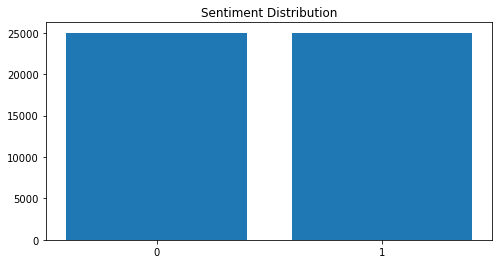

In [5]:
val_count = data_frame.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.xticks(val_count.index)
plt.title("Sentiment Distribution")

# Clean dataset: remove hyperlinks, html entities, punctuation and newline characters ...

In [6]:
from manny_train import clean_text_data as ctd


data_frame = ctd.clean_and_return(data_frame, "text")


Cleaning dataset, please wait ...
Dataset cleaned!


In [8]:
# save the cleaned dataset
data_frame.to_csv(DATASET_FOLDER+"/"+CLEAN_DATA_FILE, index = False)

# Load saved data_frame 

In [14]:
# load the clean dataset from .csv file
dtypes = {'sentiment': 'str', 'text': 'str'}
data_frame = pd.read_csv(DATASET_FOLDER+"/"+CLEAN_DATA_FILE) # make sure we import both columns as str

# clean data file
data_frame.head()



,sentiment,text
0,0,i found the documentary entitled fast cheap ...
1,0,this is an embarrassment to everyone and every...
2,0,the cast although nothing special all do an o...
3,0,investigative reporter darren mcgavin as carl ...
4,0,this movie is horrible everything in it has b...


# Wordcloud of ```positive``` sentiments

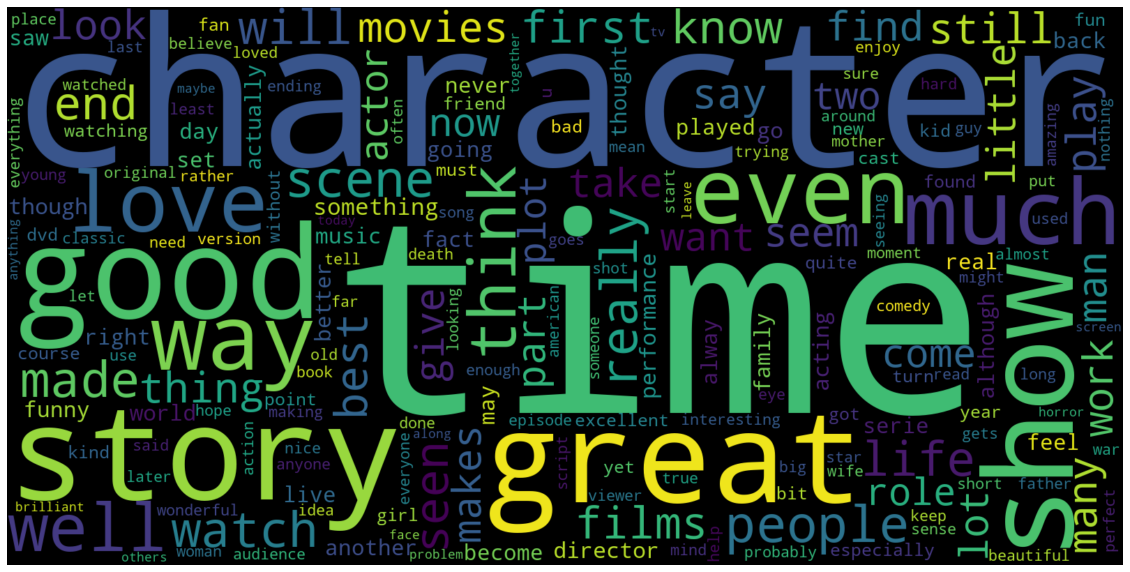

In [13]:
# add aditional stopwords
STOPWORDS.add("film")
STOPWORDS.add("movie")
STOPWORDS.add("one")
STOPWORDS.add("see")
STOPWORDS.add("make")

plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

# Wordcloud of ```negative``` sentiments

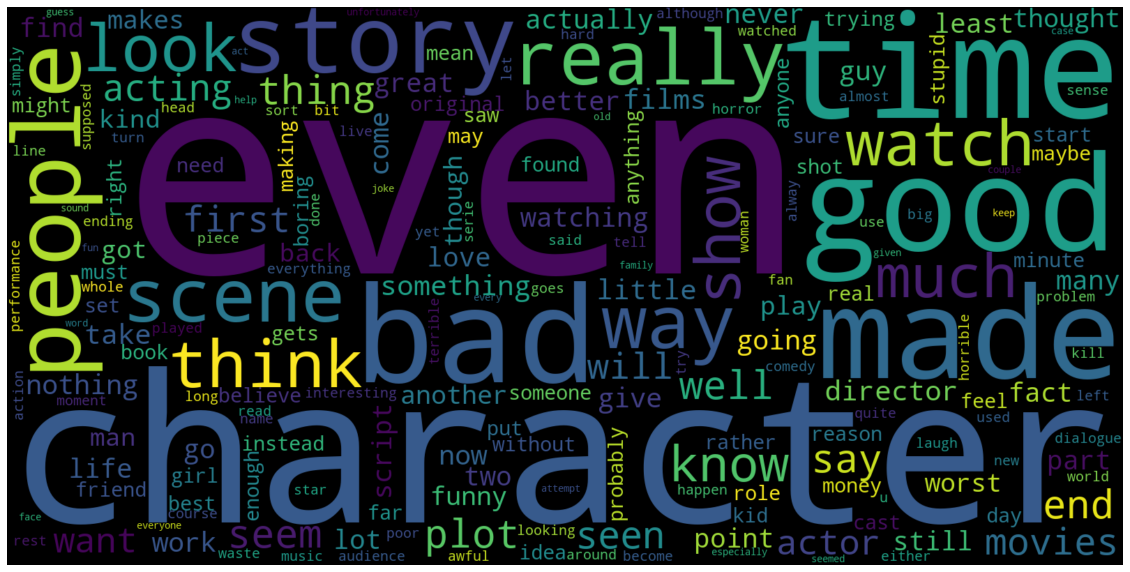

In [250]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Now we need randomise the dataset

In [15]:

data_frame = data_frame.sample(frac = 1, random_state = 7) # frac = 1 i.e. the entire data frame, random_state = Seed for the random number generator 


In [16]:
data_frame.head()


,sentiment,text
29430,1,this is a delightful movie that is so overthet...
27750,1,after i watched the films i thought why the...
47782,1,this short deals with a severely critical writ...
10498,0,just cause is one of those films that at first...
24747,0,for reasons i cannot begin to fathom dr lore...


### Now we split the data set into ```TRAINING_SPLIT``` for training and ```(1 - TRAINING_SPLIT)``` for testing
#### This will also shuffle the data set before splitting it

In [17]:
train_data, test_data = train_test_split(data_frame, test_size= (1 - TRAINING_SPLIT), random_state = 7)

In [18]:
print("Training Data:\t",len(train_data), " data points\t", TRAINING_SPLIT * 100,"%")
print("Test Data:\t",len(test_data), " data points\t", (1 - TRAINING_SPLIT) * 100 ,"%")

Training Data:	 37500  data points	 75.0 %
Test Data:	 12500  data points	 25.0 %


### Examine the training and test data sets

#### Training dataset

In [19]:
train_data.head()

,sentiment,text
36893,1,most of the bad reviews on this website blame ...
35482,1,i saw it last night on tv and was quite delig...
17954,0,this movie was disturbing not because of the ...
36701,1,this movie is a remake of two movies that were...
14821,0,bad acting combats are very awful second bet...


#### Testing dataset

In [20]:
test_data.head()

,sentiment,text
36359,1,at first i hadn't read the novel so far and i...
9729,0,the fact that this movie has been entitled to ...
15270,0,this movie would receive a much higher vote fr...
40015,1,i had no expectations never saw previews for m...
41391,1,this is an excellent movie that tackles the is...




# Tokenization of training data
- We will use the TensorFlow (Keras) Tokenizer class to tokenize our training data (see imports above)
- We define some hyperparameters we will use when performing tokenization
- First we create the Tokenizer object as well as an out of vocabulary token (oov_token) to use for encoding test data words we have not come across in our training, if we don't do this then previously-unseen words would never be unaccounted for. 
- After the Tokenizer has been created, we then fit it on the training data (we do the same for our test dataset).

<center>
<img src="images/tokenization-manning.png">
</center>



    
<center><strong>Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.</strong></center>
    


In [21]:
# hyper parameters provided to tokenizer

"""
the UNK token which will be used for out of vocabulary tokens encountered during the 
tokenizing and encoding of the test data sequences created using the word index built during 
tokenization of our training data.
"""
oov_token = '<UNK>'


"""
When we are encoding our numeric sequence representations of the text data, our tweet
string lengths will be of different lengths and so we will need to select a maximum length 
for tweets and pad shorter tweets with a padding character.

We will first calculate the size of the largest tweet string, and then use '0' as a padding character, to pad out shorter
tweets. This ensures all our sequenes of text are of the same length.

Here are specifying that we want the padding at the end of the sequence of tokens
"""
pad_type = 'post' 

# this is the default, so can just leave this off of the paramteres passed to Tokenizer



In [22]:
# Tokenize training data 
tokenizer = Tokenizer(oov_token=oov_token)

# fit to our training dataset
tokenizer.fit_on_texts(train_data.text)


# store the training datas word_index
"""
The okenization process also creates a word index. This  maps words in our 
vocabulary to their numeric representation.

This mapping is then used to encoding our sequences. 
"""
word_index = tokenizer.word_index



# Encode the training tweet sentence into sequences
"""
After tokenizing our training data we have a word-to-numeric 
mapping of our vocabulary, this is used to encode our sequences. 

Here, we are converting our text sentences from something  like 
"the cat sat on the mat" to something like "3 6 7 2 1 4" where each of 
these numbers matches to the index of the corresponding words. 

Since Neural Networks work erforming computation on numbers, 
passing in set of strings will not work. Which is why we need these sequences.

So far, this is only the training dataset, the test dataset has to be
tokenized and encoded after we have competed the training dataset.
"""
train_sequences = tokenizer.texts_to_sequences(train_data.text)
test_sequences = tokenizer.texts_to_sequences(test_data.text)



# Get max training and test sequence length and find the maximum value to use for padding
# dataset has a longer sequence - we don't want it truncated)
"""
To ensure that all our sequences are of the same length, we need to set the 
maxlen hyperparameter. Here we set it to twice the maximum length found in
our training dataset sequences.
"""

maxlen_test = max([len(x) for x in train_sequences])
maxlen_train = max([len(x) for x in train_sequences])

# set to max of the two values from the training and test sets
maxlen = max(maxlen_test,maxlen_train)

# make sure maxlen is divisible by BATCH_SIZE
while True:
    if (maxlen % BATCH_SIZE) != 0:
        maxlen += 1
    else:
        break

# Pad the training and test sequences
"""
The encoded sequences need to be the same length. 

We use the maxlen found above to set this length. This will 
pad all other sequences with extra '0's at the end ('post').
"""
train_x = pad_sequences(train_sequences, padding=pad_type, maxlen=maxlen)
test_x = pad_sequences(test_sequences, padding=pad_type, maxlen=maxlen)


# Check results of tokenization and creation of training and test sequences

In [23]:

print("Padded Training Shape:", train_x.shape,"\n")
print("maxlen (maximum length of training sequences):", maxlen)


print("\nExample Training Sequences:\n",train_sequences[1])
print("\nExample Padded Training Sequences:\n",train_x[0])

print("\n##################################################################\n")

print("Padded Testing Shape:", test_x.shape,"\n")
print("maxlen (maximum length of test sequences):", maxlen)

print("\nExample Testing sequences:\n",test_sequences[5])
print("\nExample Padded Testing Sequences:\n",test_x[9])


Padded Training Shape: (37500, 2496) 

maxlen (maximum length of training sequences): 2496

Example Training Sequences:
 [10, 206, 9, 233, 315, 20, 246, 3, 13, 176, 6162, 9, 7, 422, 5, 2, 17, 60, 158, 22, 228, 322, 3, 2502, 181, 531, 3, 252, 12, 46, 7, 127, 47, 3891, 8, 2, 186, 30, 2, 10130, 19981, 21, 6, 64, 48, 1587, 13, 405, 8, 634, 6, 337, 40, 3, 2821, 40, 2, 170, 5393, 7, 54, 1673, 254, 22, 119, 12, 11, 65, 7, 21, 176, 832, 10, 417, 111, 33, 30, 456, 39, 14, 1810, 1098, 83, 565, 8, 400, 9167, 632, 4127, 500, 18, 2, 809, 145, 8, 2, 17, 13, 2, 2340, 3, 451, 9, 45, 39, 374, 2, 131, 8, 2, 1866, 15, 108, 170, 2198, 100, 33, 66, 63, 3780, 378, 2, 265, 13, 4, 117, 225, 1395, 18, 9, 154, 583, 68, 34, 61, 61, 2830, 2, 218, 65]

Example Padded Training Sequences:
 [87  5  2 ...  0  0  0]

##################################################################

Padded Testing Shape: (12500, 2496) 

maxlen (maximum length of test sequences): 2496

Example Testing sequences:
 [7875, 4, 19, 12, 2790

# Print the first entry only, to show the actual text as a padded sequqnce

In [24]:
for x, y in zip(test_data.text, test_x):
    print('{} \n\n -- to padded sequence --> {}'.format(x, y))
    break

at first  i hadn't read the novel so far and i hadn't hear anything about the author yet  but as i casually saw this movie  i was totally captive by the story  already as the jewish watchman primary said  that he knows no one  who have a bad conscience about the war except from howard w  campbell junior  was such amazing objective and dissociates from simply moralizing the war  terrific  and the fictitious story about the most effective spy for the usa in wwii who have lost everything  that was important for his life  is wonderful emotional transcribed  this is the best story about the duality of humanity  i've ever heard about  the questions  this movie is introducing  are in my opinion very important for our society  when does someone bear the guilt of something  what is guilt  who is a hero and who is a felon  what is important in our life  can you live without paying attention to the political changes  is the protagonist guilty or not  these questions are more up to date than in th

### There are only two labels in our model (0 = negative, 1 = positive)

In [25]:
print(train_data.sentiment.unique().tolist())


[1, 0]


#### Encode training labels using scikit-learn module sklearn.preprocessing.LabelEncoder

In [26]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

train_y = encoder.transform(train_data.sentiment.to_list())
test_y = encoder.transform(test_data.sentiment.to_list())
# print("Dimensions before reshape: ",train_y.ndim)

# convert the 1 dimensional array into a 2d array as required for training 
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)

# print("Dimensions after reshape: ",train_y.ndim)
print("train_y shape:", train_y.shape)
print("test_y shape:", test_y.shape)


train_y shape: (37500, 1)
test_y shape: (12500, 1)


# Word-Embeddings
#### Word embeddings is a feature vector for each of the words that enables us to give words a ```context```.
- Instead of creating this ourselves, we will use a pre-trained embddings vectors (GloVe Embeddings)


# Functions to:
- #### Create and return an embeddings model as a dictionary ```def load_embeddings_model(embeddings_file: str) -> dict:```
- #### Create and return an embeddings matrix ```def get_embeddings_matrix(embeddings_file: str, max_vocabulary_size: int, dimension=300) -> np.ndarray:```
- #### Save a numpy array to file ```def save_numpy_array_to_file(full_path_to_file: str, max_vocabulary_size: int, npy_array: np.ndarray):```

In [27]:
MAX_VOCABULARY_SIZE = len(tokenizer.word_index) + 1

def return_all_dictionaries():
    """
    return tokenized words as a set of dictionaries, to make look-up of words easier
    """
    data_dictionary = dict()
    inv_data_dictionary = dict()

    data_dictionary['UNK'] = MAX_VOCABULARY_SIZE
    inv_data_dictionary[MAX_VOCABULARY_SIZE] = 'UNK'

#     full_data_dictionary = dict()
#     full_inverse_dictionary = dict()

    for word, idx in tokenizer.word_index.items():
        if idx < MAX_VOCABULARY_SIZE:
            inv_data_dictionary[idx] = word
            data_dictionary[word] = idx
#         full_data_dictionary[word] = idx
#         full_inverse_dictionary[idx] = word
        
    return data_dictionary, inv_data_dictionary
    
    
def load_embeddings_model(embeddings_file: str) -> dict:
    embeddings_model= {}
    
    print("Loading embeddings model to dictionary, please wait...")
    with open(embeddings_file, 'r', encoding="utf8") as f:
        for line in f:
            values = line.strip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_model[word] = coefs

    print("Finished!")
    print('Found %s word vectors in model.' %len(embeddings_model))
    return embeddings_model


    
def get_embeddings_matrix(embeddings_file: str, max_vocabulary_size: int, dimension: int) -> np.ndarray:
    
    # load a pre-trained embeddings model into a dictionary
    embeddings_model = load_embeddings_model(embeddings_file)
    
    print("\nCreating embeddings matrix ...")
    embedding_matrix = np.zeros((max_vocabulary_size, dimension))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_model.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    print("Finished!")        
    return embedding_matrix
    


def save_numpy_array_to_file(full_path_to_file: str, max_vocabulary_size: int, npy_array: np.ndarray):
    
    print("Saving file please wait...")
    full_path_to_file = full_path_to_file+"_%d.npy" % max_vocabulary_size
    np.save(full_path_to_file,npy_array) 
    print("Finished!")
    print("Saved file to: ",full_path_to_file)
    
    


In [29]:
print(MAX_VOCABULARY_SIZE)

134326


# Create embeddings matrix of words found in IMDB dataset

In [30]:
glove_embeddings_matrix = get_embeddings_matrix(GLOVE_EMBEDDINGS, MAX_VOCABULARY_SIZE, DIMENSION)


Loading embeddings model to dictionary, please wait...
Finished!
Found 2196007 word vectors in model.

Creating embeddings matrix ...
Finished!


### Shape of GloVe embeddings matrix

In [31]:
glove_embeddings_matrix.shape

(134326, 300)

In [32]:
#g_matrix = bemd.create_embeddings_matrix(glove_model, dictionary, full_dictionary, d=300)
data_dictionary, inv_data_dictionary = return_all_dictionaries()

In [42]:
# make sure our dictionaries contain the correct values
print(data_dictionary["movies"])
print(inv_data_dictionary[data_dictionary['movies']])
len(data_dictionary)

98
movies


134326

### Save GloVe Embeddings Matrix to file

In [43]:

# save glove embeddings for words found to the embedding directory
full_path_to_file = "embeddings/imdb_glove_embeddings"
save_numpy_array_to_file(full_path_to_file, MAX_VOCABULARY_SIZE, glove_embeddings_matrix)


Saving file please wait...
Finished!
Saved file to:  embeddings/imdb_glove_embeddings_134326.npy


# Create attack embeddings matrix for our vocabulary
#### (This will be used when generating attacks against the model)

In [44]:

counter_embeddings_matrix = get_embeddings_matrix(COUNTER_FITTED_VECTORS, MAX_VOCABULARY_SIZE, DIMENSION)


Loading embeddings model to dictionary, please wait...
Finished!
Found 65713 word vectors in model.

Creating embeddings matrix ...
Finished!


### Shape of our vocabulary matrix

In [45]:

print(counter_embeddings_matrix.shape)


(134326, 300)


### Save our vocabulary embeddings matrix

In [46]:

# save the counter fitted embeddings for words found
full_path_to_file = "embeddings/imdb_counter_fitted_embeddings"
save_numpy_array_to_file(full_path_to_file, MAX_VOCABULARY_SIZE, counter_embeddings_matrix)


Saving file please wait...
Finished!
Saved file to:  embeddings/imdb_counter_fitted_embeddings_134326.npy


# Check we have a GPU available for traiing the model
#### (If no GPU available then training will be done using the CPU, which is very slow!)

In [47]:
print("Number of GPUs available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if tf.test.gpu_device_name(): 
    print('GPU Device used for training will be: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU, make sure using a GPU enabled machine, or check you have GPU version of Tensorflow")

Number of GPUs available:  1
GPU Device used for training will be: /device:GPU:0


# Train the sentiment analysis model and save it to ```MODEL_SAVE_PATH```
### weights used come form the GloVe embeddings, so pass that in as a paramter

In [ ]:

# get the saved GloVe embeddings matrix
glove_embeddings_matrix = np.load(("embeddings/imdb_glove_embeddings_%d.npy" % MAX_VOCABULARY_SIZE))


In [ ]:
from  manny_train import models


LEARNING_RATE = 1e-4 # after changing learning rate - have a more stable reduction in loss value
print("Learning Rate: ",LEARNING_RATE)
model_test = models.TrainModel(glove_embeddings_matrix,
                                train_x, train_y, test_x, test_y,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                input_dim=MAX_VOCABULARY_SIZE,
                                input_length=maxlen,
                                trainable=True,
                                output_dim=DIMENSION,
                                learning_rate=LEARNING_RATE
                               )

from keras.models import load_model

history_dict = model_test.history_dict
model = model_test.model


model.save(MODEL_SAVE_PATH)  # creates a HDF5 file 'my_model.h5'


import pickle

# save history as a dictionary in case we need to plot again later
with open(TRAINING_HISORTY_SAVE_PATH, 'wb') as file_pickle:
        pickle.dump(history_dict.history, file_pickle)


In [194]:
# Model.fit(
#     x=None,
#     y=None,
#     batch_size=None,
#     epochs=1,
#     verbose=1,
#     callbacks=None,
#     validation_split=0.0,
#     validation_data=None,
#     shuffle=True,
#     class_weight=None,
#     sample_weight=None,
#     initial_epoch=0,
#     steps_per_epoch=None,
#     validation_steps=None,
#     validation_batch_size=None,
#     validation_freq=1,
#     max_queue_size=10,
#     workers=1,
#     use_multiprocessing=False,
# )


# Evaluate the model

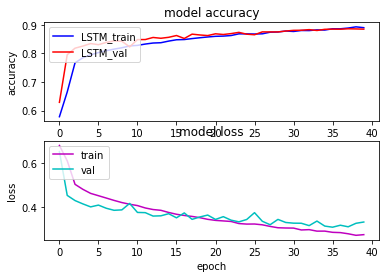

In [195]:
s, (at, al) = plt.subplots(2,1)
at.plot(history_dict.history['accuracy'], c= 'b')
at.plot(history_dict.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history_dict.history['loss'], c='m')
al.plot(history_dict.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
s.show()

In [196]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0


scores = model.predict(test_x, verbose=1, batch_size=BATCH_SIZE)
y_predictions = [decode_sentiment(score) for score in scores]


196/196 [==============================] - 30s 153ms/step


In [197]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes, title='Confusion Matrix',cmap=plt.cm.Greys, normalize=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual', fontsize=22)
    plt.xlabel('Predicted', fontsize=17)

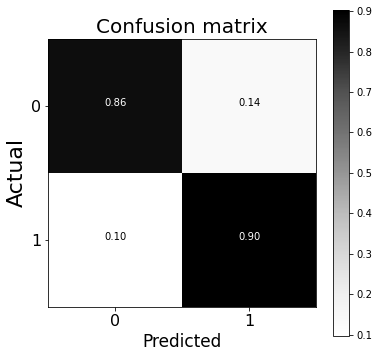

In [198]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_predictions)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.savefig('images/imdb-confusion-matrix.png',bbox_inches='tight')
plt.show()



In [199]:
print(classification_report(list(test_data.sentiment), y_predictions))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      6213
           1       0.87      0.90      0.89      6287

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



# Save the model
we can later load it from disk

In [200]:

model = load_model(MODEL_SAVE_PATH)
history_dict = pickle.load(open(TRAINING_HISORTY_SAVE_PATH, 'rb'))

In [207]:
# model.summary(line_length=None, positions=None, print_fn=None)
# model.get_weights()
# model.get_config()
model.summary()
# print(history_dict)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2240)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 2240, 300)         40171200  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 2240, 300)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2236, 64)          96064     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0   

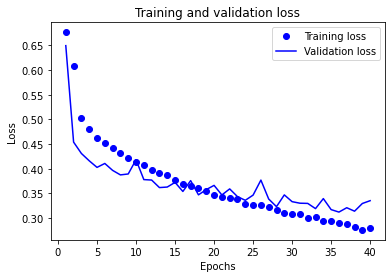

In [202]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss,'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('images/imdb-training-and-validation-loss.png',bbox_inches='tight')
plt.show()


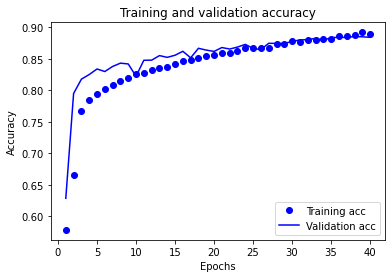

In [203]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('images/imdb-training-and-validation-accuracy.png',bbox_inches='tight')
plt.show()


# At this point we have saved the clean dataset file, model and history of the training 
### Now we can just load the model, when we need it for generating adversarial examples against it

In [ ]:
model = load_model(MODEL_SAVE_PATH)
history_dict = pickle.load(open(TRAINING_HISORTY_SAVE_PATH, 'rb'))

In [2]:
counter_embeddings_matrix  = get_embeddings_matrix(COUNTER_FITTED_VECTORS, MAX_VOCABULARY_SIZE, DIMENSION)


NameError: name 'get_embeddings_matrix' is not defined

In [92]:
print(type(counter_embeddings_matrix))
print(counter_embeddings_matrix.shape)

<class 'numpy.ndarray'>
(134303, 300)


# Loss function optomisation

In [97]:
square_matrix = -2 * np.dot(counter_embeddings_matrix.T, counter_embeddings_matrix)
print(len(c_))

300


In [98]:
a = np.sum(np.square(counter_embeddings_matrix), axis=0).reshape((1,-1))

In [99]:
b = a.T

In [100]:
len(b)

300

# Save the distance matrix

In [101]:
dist = a + b + square_matrix

In [102]:
np.save(('embeddings/distance_counterfitted_embeddings_%d.npy' % MAX_VOCABULARY_SIZE), dist)

In [103]:
src_word = data_dictionary['good'] 
#print(src_word)
neighbours, distance_to_neighbours = bemb.closest_neighbours(src_word,dist)


In [105]:
# restuls = [inv_data_dictionary[x] for x in neighbours]
# print(restuls)

In [106]:
print("data_dictionary: ",len(inv_data_dictionary))
print("full_data_dictionary: ",len(full_data_dictionary))

print("inv_data_dictionary: ",len(inv_data_dictionary))
print("full_inverse_dictionary: ",len(full_inverse_dictionary))
    

data_dictionary:  134303
full_data_dictionary:  134302
inv_data_dictionary:  134303
full_inverse_dictionary:  134302


In [107]:
IMDB_DATA = 'imdb_dataset/imdb'

MAX_VOCABULARY_SIZE = 50000
GLOVE_DATA = 'glove/glove.840B.300d.txt'
COUNTER_FITTED_VECTOR_DATA = 'counter-fitted/counter-fitted-vectors.txt'

if not os.path.exists('aux_files'):
    os.mkdir('aux_files')
imdb_dataset = build_embeddings.IMDBDataset(path=IMDB_DATA, max_vocab_size=MAX_VOCABULARY_SIZE)

# save the dataset
with open(('aux_files/dataset_%d.pkl' % MAX_VOCABULARY_SIZE), 'wb') as f:
    pickle.dump(imdb_dataset, f)

# create the glove embeddings matrix (used by the classification model)
glove_model = build_embeddings.load_glove_model(GLOVE_DATA)
glove_embeddings, _ = build_embeddings.create_embeddings_matrix(glove_model, imdb_dataset.dict, imdb_dataset.full_dict)

# print("SIZE OF GLOVE INDEX ",len(glove_model))
# print("SIZE OF MATRIX: ",len(glove_embeddings))
# print("Size of dict: ", len(imdb_dataset.dict))
# print("Size of full dict: ", len(imdb_dataset.full_dict))

# save the glove_embeddings matrix
np.save('aux_files/embeddings_glove_%d.npy' % MAX_VOCABULARY_SIZE, glove_embeddings)

# Load the counterfitted-vectors (used by our attack)
glove2 = build_embeddings.load_glove_model(COUNTER_FITTED_VECTOR_DATA)
# create embeddings matrix for our vocabulary
counter_embeddings, missed = build_embeddings.create_embeddings_matrix(glove2, imdb_dataset.dict, imdb_dataset.full_dict)

# save the embeddings for both words we have found, and words that we missed.
np.save(('aux_files/embeddings_counter_%d.npy' % MAX_VOCABULARY_SIZE), counter_embeddings)
np.save(('aux_files/missed_embeddings_counter_%d.npy' % MAX_VOCABULARY_SIZE), missed)
print('All done')


NameError: name 'build_embeddings' is not defined

In [108]:
MAX_VOCAB_SIZE = 50000
embedding_matrix = np.load(('aux_files/embeddings_counter_%d.npy' % MAX_VOCAB_SIZE))
missed = np.load(('aux_files/missed_embeddings_counter_%d.npy' % MAX_VOCAB_SIZE))




# Loss function optomization
print("dot matrix calc - return a square matrix")
c_ = -2 * np.dot(embedding_matrix.T, embedding_matrix)

print("do sum of matrix")
a = np.sum(np.square(embedding_matrix), axis=0).reshape((1, -1))
print("set b to transpose of a")
b = a.T

print("len of c_: ", len(c_))
print("len of a: ", len(a))
print("len of b: ", len(b))

# save the distance matrix
dist = a + b + c_
print("save distance matrix")
np.save(('aux_files/dist_counter_%d.npy' % MAX_VOCAB_SIZE), dist)

# Try an example
print("do an example")
with open('aux_files/dataset_%d.pkl' % MAX_VOCAB_SIZE, 'rb') as f:
    dataset = pickle.load(f)
src_word = dataset.dict['good']
neighbours, neighbours_dist = build_embeddings.closest_neighbours(src_word, dist)

print('\nClosest words to `good` are :')
result_words = [dataset.inv_dict[x] for x in neighbours]
print(result_words)


dot matrix calc - return a square matrix
do sum of matrix
set b to transpose of a
len of c_:  50001
len of a:  1
len of b:  50001
save distance matrix
do an example


NameError: name 'build_embeddings' is not defined

In [1]:

src_word = dataset.dict['bad']
neighbours, neighbours_dist = build_embeddings.closest_neighbours(src_word, dist)
print('Closest words to `bad` are :')
result_words = [dataset.inv_dict[x] for x in neighbours]
print(result_words)

NameError: name 'dataset' is not defined

In [ ]:
src_word = dataset.dict['movie']
neighbours, neighbours_dist = build_embeddings.closest_neighbours(src_word, dist, ret_count=10, threshold=0.05)
print('Closest words to `movie` are :')
result_words = [dataset.inv_dict[x] for x in neighbours]
print(result_words)
print(neighbours_dist)

In [ ]:
dist_order = np.argsort(dist[src_word, :])[1:1 + 10]
print(dist_order)

In [620]:
dist_l = dist[src_word][dist_order]
print(dist_l)

[0.00449105 0.01243462 0.01349261 0.02121319 0.2342381  0.2619053
 0.29379267 0.30176988 0.32164043 0.39107457]


In [621]:
mask = np.zeros(dist_l.shape)
print(mask)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [622]:
mask = np.where(dist_l < 0.2)
print(mask)
print(dist_l[mask])

(array([0, 1, 2, 3]),)
[0.00449105 0.01243462 0.01349261 0.02121319]
